# How to choose splits when doing cross validation
_Group 3 Presentation_

Validation

## Quick recap
 - Training, validation and testing dataset
 - Cross validation
    - Split into folds
    - Train subset
    - Validate on remaining
    - Repeat
- Goals
    - Not to achieve the "best scores"
    - Accurate representation of performance

In [ ]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# If using scikit-learn examples
from sklearn.model_selection import (KFold, StratifiedKFold, GroupKFold,
                                     StratifiedGroupKFold, TimeSeriesSplit)
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Iterator, Optional, Tuple

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

# code for plotting cv splits
# (https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10, classes=True, title=None):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    yticklabels = list(range(n_splits))

    # Plot the data classes and groups at the end
    if classes:
      ax.scatter(
          range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
      )
      yticklabels += ["class"]
    if group is not None:
      ax.scatter(
          range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
      )
      yticklabels += ["group"]

    # Formatting
    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, X.shape[0]],
    )
    if title is None:
      ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    else:
      ax.set_title(title, fontsize=15)
    return ax



class SlidingWindowSplit:
    """
    Sliding-window cross-validator for time-ordered data.

    Produces train/test indices such that:
      - Train window is a fixed length: [start, start + train_size)
      - Optional gap (embargo) between train end and test start
      - Test window is a fixed length: [train_end + gap, train_end + gap + test_size)
      - The window slides forward by 'step' each split (default = test_size)

    Parameters
    ----------
    n_splits : int or None, default=None
        Maximum number of splits to yield. If None, yields all feasible windows
        until the end of the sequence is reached.
    train_size : int
        Number of samples in each training window (fixed).
    test_size : int
        Number of samples in each test window (fixed).
    gap : int, default=0
        Number of samples to skip between the end of train and start of test
        to mitigate leakage (embargo).
    step : int or None, default=None
        How many samples the window advances between splits.
        If None, defaults to test_size (non-overlapping test windows).

    Notes
    -----
    - Assumes X is **time-ordered** along axis 0.
    - Ignores `groups`, like most scikit-learn CV splitters (except GroupKFold).
    - Similar interface to scikit-learn's TimeSeriesSplit, but with a **fixed**
      training window (sliding) instead of expanding window.

    Examples
    --------
    >>> import numpy as np
    >>> X = np.arange(20)  # 20 time steps
    >>> cv = SlidingWindowSplit(train_size=8, test_size=4, gap=1, step=4)
    >>> for tr_idx, te_idx in cv.split(X):
    ...     print(tr_idx, '->', te_idx)
    [0 1 2 3 4 5 6 7] -> [ 9 10 11 12]
    [ 4  5  6  7  8  9 10 11] -> [13 14 15 16]

    In the first split:
      - train: indices 0:8
      - gap=1: index 8 is embargoed
      - test: indices 9:13 (length 4)
    Then the window advances by step=4.
    """

    def __init__(
        self,
        *,
        n_splits: Optional[int] = None,
        train_size: Optional[int] = None,
        test_size: Optional[int] = None,
        gap: int = 0,
        step: Optional[int] = None,
    ) -> None:
        if train_size is None or test_size is None:
            raise ValueError("Both 'train_size' and 'test_size' must be provided.")
        if train_size <= 0 or test_size <= 0:
            raise ValueError("'train_size' and 'test_size' must be positive integers.")
        if gap < 0:
            raise ValueError("'gap' must be >= 0.")
        if n_splits is not None and n_splits <= 0:
            raise ValueError("'n_splits' must be a positive integer or None.")
        if step is not None and step <= 0:
            raise ValueError("'step' must be a positive integer or None.")

        self.n_splits = n_splits
        self.train_size = int(train_size)
        self.test_size = int(test_size)
        self.gap = int(gap)
        self.step = int(step) if step is not None else None

    def get_n_splits(self, X=None, y=None, groups=None) -> int:
        """
        Return the number of splits. If n_splits was specified, returns it.
        Otherwise, requires X to compute the maximum feasible number of splits.
        """
        if self.n_splits is not None:
            return self.n_splits
        if X is None:
            raise ValueError(
                "X must be provided to compute the number of feasible splits "
                "when 'n_splits=None'."
            )
        n_samples = self._num_samples(X)
        return self._max_feasible_splits(n_samples)

    def split(self, X, y=None, groups=None) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        """
        Generate indices to split data into training and test set.

        Parameters
        ----------
        X : array-like of shape (n_samples, ...)
            Time-ordered data along axis 0.
        y : Ignored
        groups : Ignored
        """
        n_samples = self._num_samples(X)

        step = self.step if self.step is not None else self.test_size
        total_needed = self.train_size + self.gap + self.test_size

        if n_samples < total_needed:
            raise ValueError(
                "Not enough samples for a single split: need at least "
                f"train_size + gap + test_size = {total_needed}, got {n_samples}."
            )

        # How many starts are possible if we slide by 'step'?
        max_start = n_samples - total_needed
        feasible = max_start // step + 1
        n_yield = feasible if self.n_splits is None else min(self.n_splits, feasible)

        for i in range(n_yield):
            start = i * step
            tr_start = start
            tr_end = tr_start + self.train_size
            te_start = tr_end + self.gap
            te_end = te_start + self.test_size

            train_idx = np.arange(tr_start, tr_end, dtype=int)
            test_idx = np.arange(te_start, te_end, dtype=int)

            # Safety checks (should hold by construction)
            if train_idx.size != self.train_size or test_idx.size != self.test_size:
                # This should not trigger if calculations are correct
                continue
            if te_end > n_samples:
                break

            yield train_idx, test_idx

    # ---- helpers ----
    @staticmethod
    def _num_samples(X) -> int:
        try:
            return len(X)
        except TypeError:
            # Fallback: numpy-like
            return X.shape[0]

    def _max_feasible_splits(self, n_samples: int) -> int:
        step = self.step if self.step is not None else self.test_size
        total_needed = self.train_size + self.gap + self.test_size
        if n_samples < total_needed:
            return 0
        max_start = n_samples - total_needed
        return max_start // step + 1

    def __repr__(self) -> str:
        return (
            f"SlidingWindowSplit(n_splits={self.n_splits}, train_size={self.train_size}, "
            f"test_size={self.test_size}, gap={self.gap}, step={self.step})"
        )


## Non-timeseries data

Non–time series data is data without an inherent temporal order—rows don’t represent a sequence over time to be respected during modeling. Samples may be independent (i.i.d.) or have other structures (groups, spatial correlation, class imbalance), but there’s no built-in “past→future” direction as in time series. Typical examples: tabular datasets of patients, buildings, products, or images where order can be shuffled without violating the problem.

Code: Setup + Data + Helpers. About the dataset: The Palmer Penguins dataset contains measurements on 344 penguins from three species (Adelie, Chinstrap, Gentoo) collected on three islands (Biscoe, Dream, Torgersen) in the Palmer Archipelago, Antarctica, with features including bill length and depth (mm), flipper length (mm), body mass (g), and sex (male/female); it is widely used as a clean, modern alternative to the Iris dataset for classification tasks and is particularly useful for demonstrating cross-validation methods because the island variable provides a natural grouping factor for GroupKFold.

In [ ]:
# ===== Setup =====
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from IPython.display import display

from sklearn.datasets import fetch_openml
from sklearn.model_selection import (
    KFold, StratifiedKFold, GroupKFold, LeaveOneOut, LeavePOut, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# ===== Load Palmer Penguins (needs internet first run) =====
peng = fetch_openml("penguins", version=1, as_frame=True)
df = peng.frame

# Normalize column names (OpenML variants)
df = df.rename(columns={
    "culmen_length_mm": "bill_length_mm",
    "culmen_depth_mm": "bill_depth_mm",
})

# Keep required columns and drop missing rows (small dataset → simple demo)
needed = [
    "species", "island", "bill_length_mm", "bill_depth_mm",
    "flipper_length_mm", "body_mass_g", "sex"
]
df = df[needed].dropna().reset_index(drop=True)

# Split target, groups, features
y = df["species"]
groups = df["island"]
X = df.drop(columns=["species", "island"])

# Preprocessing + model pipeline (no leakage during CV)
numeric_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
categorical_features = ["sex"]

preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

clf_pipe = Pipeline([
    ("preproc", preproc),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs")),
])

print(f"Rows after cleaning: {len(df)}; classes: {y.unique().tolist()}; islands (groups): {groups.unique().tolist()}")

# ===== Helpers =====
def summarize_scores(name, scores, start_time):
    duration = time.time() - start_time
    return {
        "method": name,
        "mean": float(np.mean(scores)),
        "std": float(np.std(scores)),
        "n_folds": int(len(scores)),
        "time_sec": duration,
    }

def barplot_mean_std(df_plot, title=None):
    fig, ax = plt.subplots(figsize=(10.5, 5))
    labels = ["\n".join(textwrap.wrap(m, width=18)) for m in df_plot["method"]]
    ax.bar(labels, df_plot["mean"], yerr=df_plot["std"], capsize=6)
    ax.set_ylabel("Accuracy (mean ± std)")
    if title:
        ax.set_title(title)
    ax.tick_params(axis="x", labelsize=10)
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Collect results across cells
summaries = []


Rows after cleaning: 334; classes: ['Adelie', 'Chinstrap', 'Gentoo']; islands (groups): ['Torgersen', 'Biscoe', 'Dream']


K-Fold: Split data into k equal folds; train on k−1, validate on 1; repeat k times and average.

In [ ]:
start = time.time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(clf_pipe, X, y, cv=kf, scoring="accuracy")
kf_summary = summarize_scores("KFold (k=5)", kf_scores, start)
summaries.append(kf_summary)

print("K-Fold (k=5) results:")
display(pd.DataFrame([kf_summary]).round(4))


K-Fold (k=5) results:


,method,mean,std,n_folds,time_sec
0,KFold (k=5),0.994,0.0074,5,0.9324


Stratified K-Fold: Like K-Fold but each fold preserves class proportions (for classification/imbalanced classes).

In [ ]:
start = time.time()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_scores = cross_val_score(clf_pipe, X, y, cv=skf, scoring="accuracy")
skf_summary = summarize_scores("StratifiedKFold (k=5)", skf_scores, start)
summaries.append(skf_summary)

print("Stratified K-Fold (k=5) results:")
display(pd.DataFrame([skf_summary]).round(4))


Stratified K-Fold (k=5) results:


,method,mean,std,n_folds,time_sec
0,StratifiedKFold (k=5),0.994,0.0119,5,0.79


Group K-Fold: Split by group IDs so the same group never appears in both train and validation within a fold.

In [ ]:
n_groups = groups.nunique()
gk_splits = min(5, n_groups)

start = time.time()
gkf = GroupKFold(n_splits=gk_splits)
gkf_scores = cross_val_score(clf_pipe, X, y, cv=gkf, groups=groups, scoring="accuracy")
gkf_summary = summarize_scores(f"GroupKFold (k={gk_splits}, groups=island)", gkf_scores, start)
summaries.append(gkf_summary)

print(f"Group K-Fold (k={gk_splits}) results:")
display(pd.DataFrame([gkf_summary]).round(4))


Group K-Fold (k=3) results:


,method,mean,std,n_folds,time_sec
0,"GroupKFold (k=3, groups=island)",0.5718,0.3115,3,0.5514


LOOCV (Leave-One-Out): Make n folds of size 1; train on n−1, test on the 1 left out; average over all n.

In [ ]:
start = time.time()
loo = LeaveOneOut()
loo_scores = cross_val_score(clf_pipe, X, y, cv=loo, scoring="accuracy")
loo_summary = summarize_scores("LOOCV", loo_scores, start)
summaries.append(loo_summary)

print("LOOCV results:")
display(pd.DataFrame([loo_summary]).round(4))


LOOCV results:


,method,mean,std,n_folds,time_sec
0,LOOCV,0.994,0.0772,334,17.8377


Leave-P-Out: Test on every combination of p samples, train on the rest; average—very thorough but computationally heavy.

In [ ]:
start = time.time()
lpo = LeavePOut(p=2)
scores = []
# Cap to keep runtime reasonable; increase if you want
for i, (tr_idx, te_idx) in enumerate(lpo.split(X, y)):
    if i >= 200:
        break
    clf_pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    scores.append(clf_pipe.score(X.iloc[te_idx], y.iloc[te_idx]))
lpo_scores = np.array(scores)
lpo_summary = summarize_scores("LeavePOut (p=2, 200 subsamples)", lpo_scores, start)
summaries.append(lpo_summary)

print("Leave-P-Out (p=2) results (first 200 splits):")
display(pd.DataFrame([lpo_summary]).round(4))


Leave-P-Out (p=2) results (first 200 splits):


,method,mean,std,n_folds,time_sec
0,"LeavePOut (p=2, 200 subsamples)",0.995,0.0497,200,4.4743


Final comparison plot + table

All methods summary:


,method,mean,std,n_folds,time_sec
0,KFold (k=5),0.9940,0.0074,5,0.9324
1,StratifiedKFold (k=5),0.9940,0.0119,5,0.7900
2,"GroupKFold (k=3, groups=island)",0.5718,0.3115,3,0.5514
3,LOOCV,0.9940,0.0772,334,17.8377
4,"LeavePOut (p=2, 200 subsamples)",0.9950,0.0497,200,4.4743


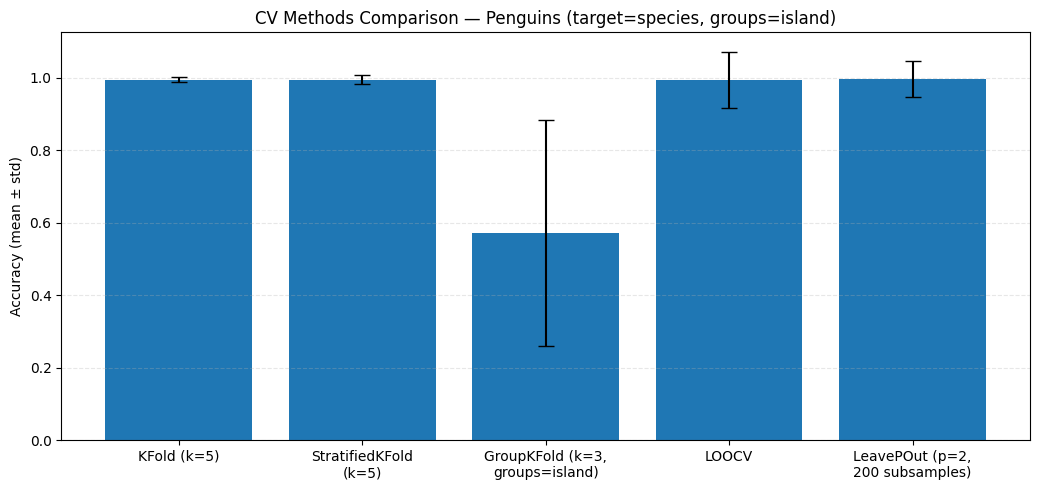

In [ ]:
summary_df = pd.DataFrame(summaries)
summary_df_round = summary_df.copy()
summary_df_round[["mean","std","time_sec"]] = summary_df_round[["mean","std","time_sec"]].round(4)

print("All methods summary:")
display(summary_df_round)

barplot_mean_std(
    summary_df_round,
    title="CV Methods Comparison — Penguins (target=species, groups=island)"
)


# Cross-validation methods (i.i.d. data): quick guide

| Method              | What it does | Use when… | Strengths | Weaknesses |
|---------------------|--------------|-----------|-----------|------------|
| **K-Fold (k=5/10)** | Split data into k equal folds; train on k−1, validate on 1; average scores. | General i.i.d. datasets with balanced classes. | Stable estimate, good data usage. | Can get imbalanced folds by chance. |
| **Stratified K-Fold** | Like K-Fold but preserves **class ratios** in each fold. | **Classification**, especially with class imbalance or rare classes. | More reliable/low variance than plain K-Fold on imbalanced data. | Not native for regression (need binning). |
| **Group K-Fold**    | Splits by **group**: the same group never appears in both train & val. | When samples are clustered (patient IDs, devices, buildings, islands, etc.). | Prevents leakage across correlated samples. | Requires group labels; `n_splits ≤ #groups`. |
| **LOOCV**           | n folds of size 1; train on n−1, test on 1; average. | Very **small datasets** where every sample counts. | Low bias (almost all data used for training). | High variance per fold; computationally heavy. |
| **Leave-P-Out (LPO)** | All combinations leaving out **p** points as validation. | Tiny datasets; stress-test sensitivity. | Thorough, flexible. | Combinatorial explosion as p↑; slow. |


## Timeseries data

* Don't randomize, keep data in temporal order
* Align folds with temporal cycles







In [ ]:
class LagFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='y', exog_cols=['u'], y_lags=2, u_lags=1, dropna=True):
        self.target_col = target_col
        self.exog_cols = exog_cols
        self.y_lags = y_lags
        self.u_lags = u_lags
        self.dropna = dropna
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for L in range(1, self.y_lags+1):
            X[f'y_lag{L}'] = X[self.target_col].shift(L)
        for col in self.exog_cols:
            for L in range(1, self.u_lags+1):
                X[f'{col}_lag{L}'] = X[col].shift(L)
        if self.dropna:
            X = X.dropna()
        return X

def create_ts_data(T=1500, change_u=0, seed=42, plot=False):
  # prepare data
  # Generate an ARX(2,1) process with exogenous input u_t
  np.random.seed(seed)
  u = np.random.randn(T)
  epsilon = 0.2*np.random.randn(T)
  y = np.zeros(T)
  for t in range(2, T):
      y[t] = 0.6*y[t-1] - 0.2*y[t-2] + (0.3 + change_u*t)*u[t-1] + epsilon[t]

  ts = pd.DataFrame({'y': y, 'u': u})
  # print(ts.head())

  # Create supervised matrix with lags (drop current y)
  feat = LagFeaturizer(y_lags=2, u_lags=1)
  Z = feat.fit_transform(ts)
  X = Z.drop(columns=['y']).values
  Y = Z['y'].values
  # len(X), len(Y)
  # print(Z.head())
  if plot:
    ts.plot(subplots=True)
  return ts, X, Y

def do_cv(cv, X, Y):
  rmse = []
  for tr, te in cv.split(X):
      model = Ridge(alpha=1.0)
      model.fit(X[tr], Y[tr])
      pred = model.predict(X[te])
      rmse.append(np.sqrt(mean_squared_error(Y[te], pred)))
  return rmse

ts, X, Y = create_ts_data()

Random K-fold vs Blocked K-fold

<Axes: title={'center': 'Random k-fold'}, xlabel='Sample index', ylabel='CV iteration'>

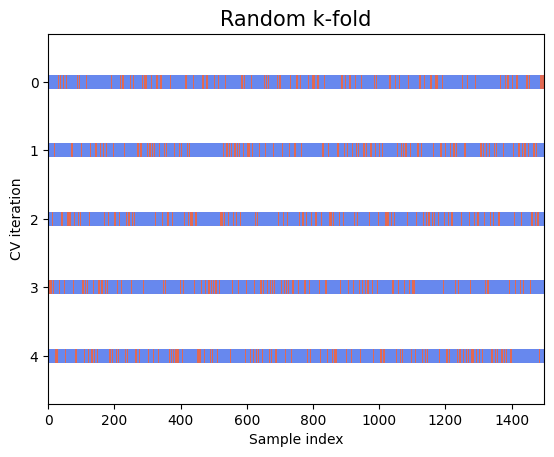

In [ ]:
n_splits = 5
cv_kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fig, ax = plt.subplots()
plot_cv_indices(cv_kf, X, Y, None, ax, n_splits, classes=False, title="Random k-fold")

<Axes: title={'center': 'Blocked k-fold'}, xlabel='Sample index', ylabel='CV iteration'>

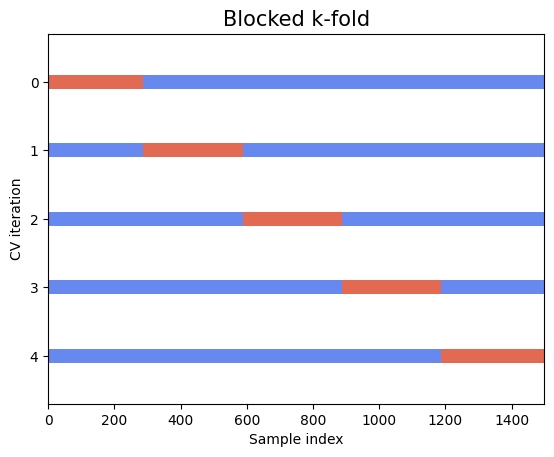

In [ ]:
n_splits=5
fig, ax = plt.subplots()
cv_bkf = KFold(n_splits)
# cv.split(X, Y)
plot_cv_indices(cv_bkf, X, Y, None, ax, n_splits, classes=False, title="Blocked k-fold")

In [ ]:
# WARNING: Demonstration only — do not use KFold on time series if you are creating forecast models
rmse_kf = do_cv(cv_kf, X, Y)
print("Random KFold RMSE: mean:", np.mean(rmse_kf).round(4), " |  std:", np.std(rmse_kf).round(4))

# blocked K-fold
rmse_bkf = do_cv(cv_bkf, X, Y)
print("Blocked KFold RMSE: mean:", np.mean(rmse_bkf).round(4), " |  std:", np.std(rmse_bkf).round(4))




Random KFold RMSE: mean: 0.1968  |  std: 0.0084
Blocked KFold RMSE: mean: 0.1972  |  std: 0.0045



## Forecasting
Learning from the past to predict the future
- **Expanding window**: training grows, test moves forward
- **Rolling/sliding window**: fixed size training sets that roll forward
- **Gap**: skip a buffer between train end and test start to prevent lag/leakage?
  - Not a problem if lags are created after splitting
  - Lags contain information about the past, not the future
  

<Axes: title={'center': 'Expanding window'}, xlabel='Sample index', ylabel='CV iteration'>

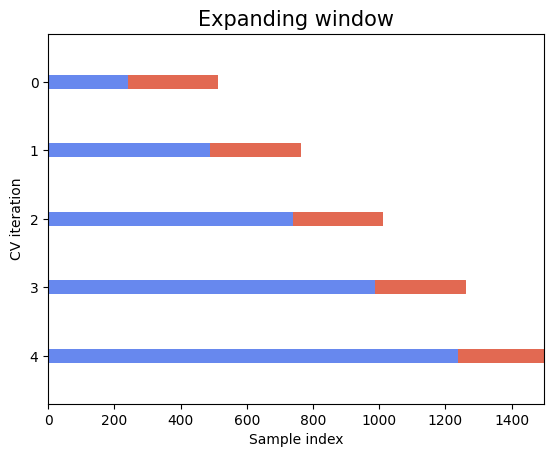

In [ ]:
n_splits=5
gap = 10
fig, ax = plt.subplots()
cv_ew = TimeSeriesSplit(n_splits, gap=gap)
# cv.split(X, Y)
plot_cv_indices(cv_ew, X, Y, None, ax, n_splits, classes=False, title="Expanding window")

In [ ]:
# Time-aware CV
# splitter = TimeSeriesSplit(n_splits=5, test_size=150, gap=5)
rmse_ew = do_cv(cv_ew, X, Y)
print("Expanding window RMSE: mean:", np.mean(rmse_ew).round(4), " |  std:", np.std(rmse_ew).round(4))

Expanding window RMSE: mean: 0.1975  |  std: 0.0062


### Sliding-window CV (fixed training length)
Use when concept drift is likely; only the **most recent** history matters.

- Need to choose size of training/test sets and step lenght
- Real world application and domain knowledge is key
- Evaluate on the your forecast horizon

<Axes: title={'center': 'Sliding window'}, xlabel='Sample index', ylabel='CV iteration'>

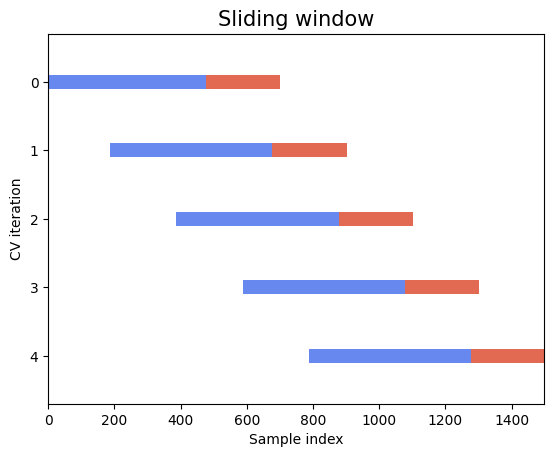

In [ ]:

n_splits=5
gap = 0
fig, ax = plt.subplots()
cv_sw = SlidingWindowSplit(n_splits=n_splits, train_size=490, test_size=200, gap=gap)
# cv.split(X, Y)
plot_cv_indices(cv_sw, X, Y, None, ax, n_splits, classes=False, title="Sliding window")

In [ ]:
# n = len(Y)
# splitter = SlidingWindowSplit(n_splits=n_splits, train_size=490, test_size=200, step=10, gap=gap)
rmse_sw = do_cv(cv_sw, X, Y)
print("Sliding-window RMSE: mean:", np.mean(rmse_sw).round(4), " |  std:", np.std(rmse_sw).round(4))

Sliding-window RMSE: mean: 0.1974  |  std: 0.0088


<Axes: title={'center': 'Sliding window'}, xlabel='Sample index', ylabel='CV iteration'>

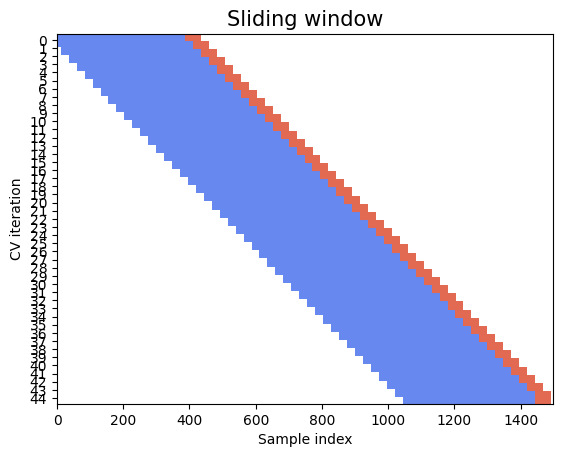

In [ ]:

n_splits=45
gap = 0
fig, ax = plt.subplots()
cv_sw2 = SlidingWindowSplit(n_splits=n_splits, train_size=400, test_size=24, gap=gap, step=24,)
# cv.split(X, Y)
plot_cv_indices(cv_sw2, X, Y, None, ax, n_splits, classes=False, title="Sliding window")

In [ ]:
n = len(Y)
# splitter = SlidingWindowSplit(n_splits=n_splits, train_size=400, test_size=20, step=10, gap=gap)
rmse_sw2 = do_cv(cv_sw2, X, Y)
print("Sliding-window RMSE: mean:", np.mean(rmse_sw2).round(4), " |  std:", np.std(rmse_sw2).round(4))

Sliding-window RMSE: mean: 0.1972  |  std: 0.0258


In [ ]:
print("Random KFold RMSE: mean:", np.mean(rmse_kf).round(4), " |  std:", np.std(rmse_kf).round(4))
print("Blocked KFold RMSE: mean:", np.mean(rmse_bkf).round(4), " |  std:", np.std(rmse_bkf).round(4))
print("Expanding window RMSE: mean:", np.mean(rmse_ew).round(4), " |  std:", np.std(rmse_ew).round(4))
print("Sliding-window RMSE: mean:", np.mean(rmse_sw).round(4), " |  std:", np.std(rmse_sw).round(4))
print("Sliding-window RMSE: mean:", np.mean(rmse_sw2).round(4), " |  std:", np.std(rmse_sw2).round(4))

Random KFold RMSE: mean: 0.1968  |  std: 0.0084
Blocked KFold RMSE: mean: 0.1972  |  std: 0.0045
Expanding window RMSE: mean: 0.1975  |  std: 0.0062
Sliding-window RMSE: mean: 0.1974  |  std: 0.0088
Sliding-window RMSE: mean: 0.1972  |  std: 0.0258


## Example

We generate synthetic time series data using an autoregressive model with exogenous input (ARX). The model includes:

$$
y_k = 0.6 y_{k-1} - 0.2 y_{k-2} + 0.3 u_{k-1} + \varepsilon_t
$$

Then we fit the same linear model on the data:

$$
y_k = θ_1 y_{k-1} - \theta_2 y_{k-2} + \theta_3 u_{k-1} + \varepsilon_t
$$

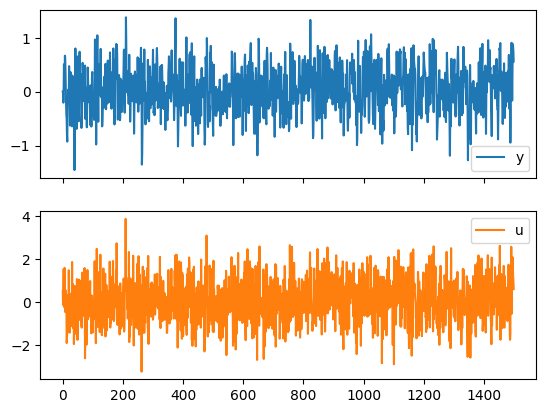

In [ ]:
# Create data
ts, X, Y = create_ts_data(plot=True)

Then we do cross validation with the same linear model on the data:

$$
y_k = θ_1 y_{k-1} - \theta_2 y_{k-2} + \theta_3 u_{k-1} + \varepsilon_t
$$

In [ ]:
# do CV
rmse_kf = do_cv(cv_kf, X, Y)
rmse_bkf = do_cv(cv_bkf, X, Y)
rmse_ew = do_cv(cv_ew, X, Y)
rmse_sw = do_cv(cv_sw, X, Y)
rmse_sw2 = do_cv(cv_sw2, X, Y)

print("Random KFold RMSE:     mean:", np.mean(rmse_kf).round(4), " |  std:", np.std(rmse_kf).round(4))
print("Blocked KFold RMSE:    mean:", np.mean(rmse_bkf).round(4), " |  std:", np.std(rmse_bkf).round(4))
print("Expanding window RMSE: mean:", np.mean(rmse_ew).round(4), " |  std:", np.std(rmse_ew).round(4))
print("Sliding-window RMSE:   mean:", np.mean(rmse_sw).round(4), " |  std:", np.std(rmse_sw).round(4))
print("Sliding-window RMSE:   mean:", np.mean(rmse_sw2).round(4), " |  std:", np.std(rmse_sw2).round(4))

Random KFold RMSE:     mean: 0.1968  |  std: 0.0084
Blocked KFold RMSE:    mean: 0.1972  |  std: 0.0045
Expanding window RMSE: mean: 0.1975  |  std: 0.0062
Sliding-window RMSE:   mean: 0.1974  |  std: 0.0088
Sliding-window RMSE:   mean: 0.1972  |  std: 0.0258


## Example 2

We make the influence of the input time variying
$$
y_k = 0.6 y_{k-1} - 0.2 y_{k-2} + \left(0.3 + 0.01 \cdot k \right) u_{k-1} + \varepsilon_k
$$

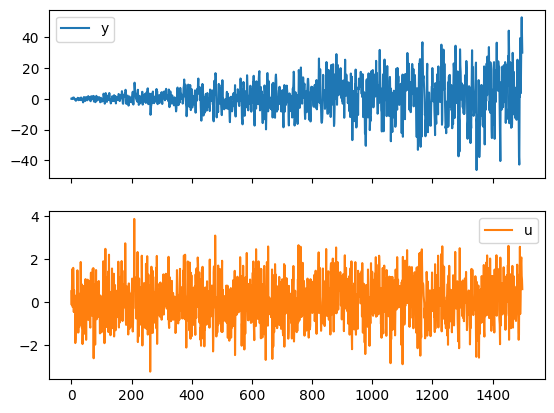

In [ ]:
# create data
ts, X, Y = create_ts_data(change_u=1e-2, plot=True)

We do Cross validation again (with the same linear model)

In [ ]:
#do CV
rmse_kf = do_cv(cv_kf, X, Y)
rmse_bkf = do_cv(cv_bkf, X, Y)
rmse_ew = do_cv(cv_ew, X, Y)
rmse_sw = do_cv(cv_sw, X, Y)
rmse_sw2 = do_cv(cv_sw2, X, Y)

print("Random KFold RMSE:     mean:", np.mean(rmse_kf).round(4), " |  std:", np.std(rmse_kf).round(4))
print("Blocked KFold RMSE:    mean:", np.mean(rmse_bkf).round(4), " |  std:", np.std(rmse_bkf).round(4))
print("Expanding window RMSE: mean:", np.mean(rmse_ew).round(4), " |  std:", np.std(rmse_ew).round(4))
print("Sliding-window RMSE:   mean:", np.mean(rmse_sw).round(4), " |  std:", np.std(rmse_sw).round(4))
print("Sliding-window RMSE:   mean:", np.mean(rmse_sw2).round(4), " |  std:", np.std(rmse_sw2).round(4))

Random KFold RMSE:     mean: 4.3065  |  std: 0.1944
Blocked KFold RMSE:    mean: 4.7066  |  std: 2.4827
Expanding window RMSE: mean: 5.0875  |  std: 1.7518
Sliding-window RMSE:   mean: 3.4915  |  std: 0.1455
Sliding-window RMSE:   mean: 2.1095  |  std: 0.3164


## Benefits and drawbacks

### Benefits
- Reliable performance estimates
- Effiecient use of data
- Comparison of model types

### Drawbacks
- Computational cost
- Complexity for certain datatypes
- Data leakage

## Conculsions
- Random splits is only valid for iid data

#### Split in a way that makes sense for your real world application